In [2]:

# Object Detecion 
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline

c:\Users\Utilisateur\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# A Vehicle Detection and Counting project based on the Yolo V8 Model.
----------------------
 **The objectives of the project are:**
 - Detect vehicles in an highway - (cars, trucks, bus and motorcycles)
 - Count the number of vehicles that pass thought a transition line indicating the direction they are going to. ( in\ou)
 - Count the total number of each class have passed in the highway
 
 --------------------

In [3]:
# Video  path for experiment
path = "D:/PERSO/yolo/roc_laval_4k_60s.mp4"


In [4]:
# Displaying the target video 
frac = 0.65 
#display(Video(data=path, height=int(720*frac), width=int(1280*frac)))
Video(path, width=640, height=360)

In [4]:
#loading a YOLO model 
model = YOLO('yolov8n.pt')
#model = YOLO('yolov8s.pt')

#geting names from classes
dict_classes = model.model.names
dict_classes

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [6]:
# Auxiliary functions
def resize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    return resized


# Detecting Vehicles 

In [7]:

### Configurations
#Verbose during prediction
verbose = False
# Scaling percentage of original frame
scale_percent = 50


#-------------------------------------------------------
# Reading video with cv2
video = cv2.VideoCapture(path)


# Objects to detect Yolo
class_IDS = [2, 3, 5, 7] 
#class_IDS = [8] 
# Auxiliary variables
centers_old = {}
centers_new = {}
obj_id = 0 
veiculos_contador_in = dict.fromkeys(class_IDS, 0)
veiculos_contador_out = dict.fromkeys(class_IDS, 0)
end = []
frames_list = []
cy_linha = int(1500 * scale_percent/100 )
cx_sentido = int(2000 * scale_percent/100) 
offset =2.5# int(8 * scale_percent/100 )
contador_in = 0
contador_out = 0
print(f'[INFO] - Verbose during Prediction: {verbose}')


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance 
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (3840, 2160)
[INFO] - Scaling change may cause errors in pixels lines 
[INFO] - Dim Scaled:  (1920, 1080)


In [8]:

    

#-------------------------------------------------------
### Video output ####
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))


#-------------------------------------------------------
# Executing Recognition 
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):
    
    # reading frame from video
    _, frame = video.read()
    
    #Applying resizing of read frame
    frame  = resize_frame(frame, scale_percent)
    
    if verbose:
        print('Dimension Scaled(frame): ', (frame.shape[1], frame.shape[0]))

    # Getting predictions
    y_hat = model.predict(frame, conf = 0.5, iou=0.5, classes = class_IDS, device = 'cpu', verbose = False, retina_masks=False, augment=False)
    
    # Getting the bounding boxes, confidence and classes of the recognize objects in the current frame.
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy() 
    
    # Storing the above information in a dataframe
    positions_frame = pd.DataFrame(y_hat[0].cpu().numpy().boxes.data, columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])
    
    #Translating the numeric class labels to text
    labels = [dict_classes[i] for i in classes]
    
    # Drawing transition line for in\out vehicles counting 
    cv2.line(frame, (0, cy_linha), (int(4500 * scale_percent/100 ), cy_linha), (255,255,0),8)#8 #Le dernier chiffre correspond à l'épaisseur de la ligne en pixel
    
    # For each vehicles, draw the bounding-box and counting each one the pass thought the transition line (in\out)
    for ix, row in enumerate(positions_frame.iterrows()):
        # Getting the coordinates of each vehicle (row)
        xmin, ymin, xmax, ymax, confidence, category,  = row[1].astype('int')
        
        # Calculating the center of the bounding-box
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)
        
        # drawing center and bounding-box of vehicle in the given frame 
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 4) # box #5
        cv2.circle(frame, (center_x,center_y), 1,(255,0,0),-1) # center of box
        
        #Drawing above the bounding-box the name of class recognized.
        cv2.putText(img=frame, text=labels[ix]+' - '+str(np.round(conf[ix],2)),
                    org= (xmin,ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=1)
        
        # Checking if the center of recognized vehicle is in the area given by the transition line + offset and transition line - offset 
        if (center_y < (cy_linha + offset)) and (center_y > (cy_linha - offset)):
            if  (center_x >= 0) and (center_x <=cx_sentido):
                contador_in +=1
                veiculos_contador_in[category] += 1
            else:
                contador_out += 1
                veiculos_contador_out[category] += 1
    
    #updating the counting type of vehicle 
    contador_in_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_in.items()]
    contador_out_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_out.items()]
    
    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text='X entrants', 
                org= (30,30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=1, color=(0, 0, 0),thickness=1)
    
    cv2.putText(img=frame, text='X sortants', 
                org= (int(2800 * scale_percent/100 ),30), 
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0,0),thickness=1)
    
    #drawing the counting of type of vehicles in the corners of frame 
    xt = 40
    for txt in range(len(contador_in_plt)):
        xt +=30
        cv2.putText(img=frame, text=contador_in_plt[txt], 
                    org= (30,xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                    fontScale=1, color=(0, 0, 0),thickness=1)
        
        cv2.putText(img=frame, text=contador_out_plt[txt],
                    org= (int(2800 * scale_percent/100 ),xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=1, color=(0, 0, 0),thickness=1)
    
    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text=f'Input:{contador_in}', 
                org= (int(1820 * scale_percent/100 ),cy_linha+60),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)
    
    cv2.putText(img=frame, text=f'Output:{contador_out}', 
                org= (int(1800 * scale_percent/100 ),cy_linha-40),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)

    if verbose:
        print(contador_in, contador_out)
    #Saving frames in a list 
    frames_list.append(frame)
    #saving transformed frames in a output video formaat
    output_video.write(frame)
    
#Releasing the video    
output_video.release()


####  pos processing
# Fixing video output codec to run in the notebook\browser
if os.path.exists(output_path):
    os.remove(output_path)
    


  0%|          | 0/3666 [00:00<?, ?it/s]

'subprocess.run(\n    ["ffmpeg",  "-i", tmp_output_path,"-crf","18","-preset","veryfast","-hide_banner","-loglevel","error","-vcodec","libx264",output_path])\nos.remove(tmp_output_path)'

In [9]:
import subprocess

command = [
    "ffmpeg",
    "-i", tmp_output_path,
    "-crf", "18",
    "-preset", "veryfast",
    "-hide_banner",
    "-loglevel", "error",
    "-vcodec", "libx264",
    output_path
]

subprocess.run(command,shell=True)

CompletedProcess(args=['ffmpeg', '-i', 'tmp_rep_result.mp4', '-crf', '18', '-preset', 'veryfast', '-hide_banner', '-loglevel', 'error', '-vcodec', 'libx264', 'rep_result.mp4'], returncode=1)

# Sampling Transformed Frames Results

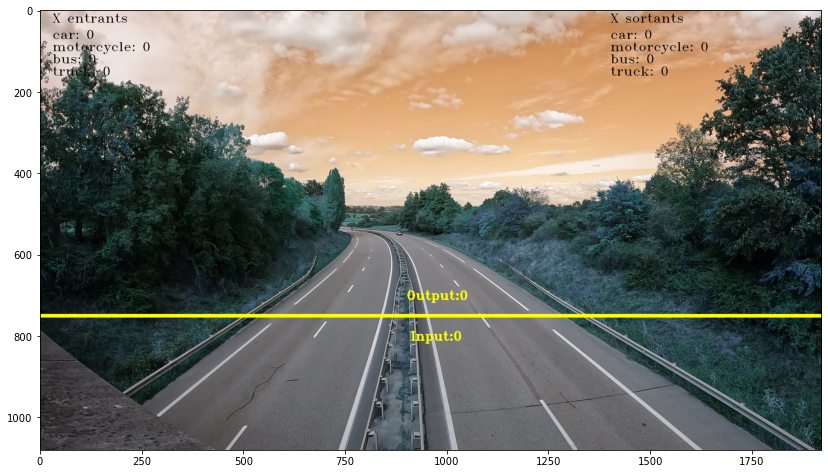

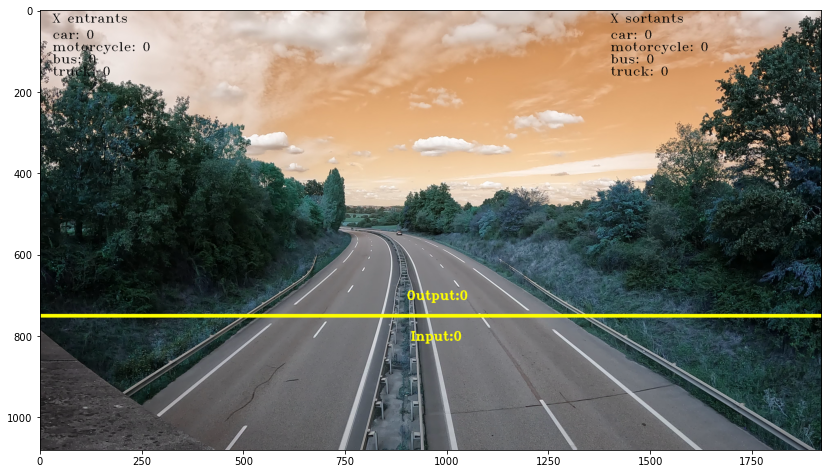

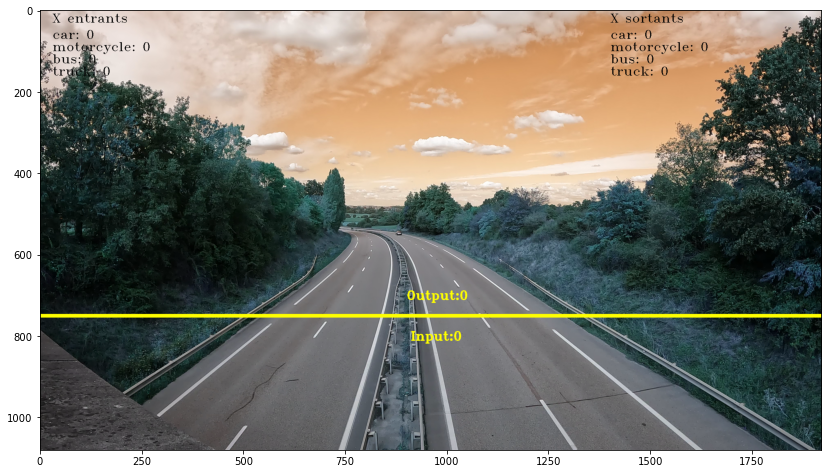

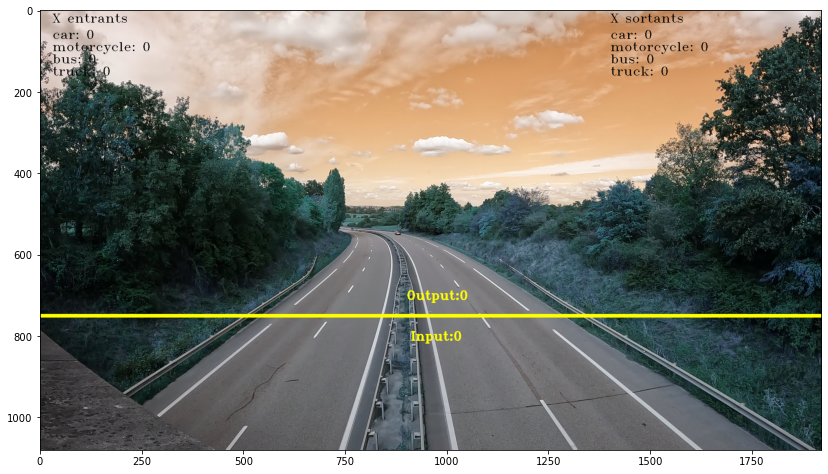

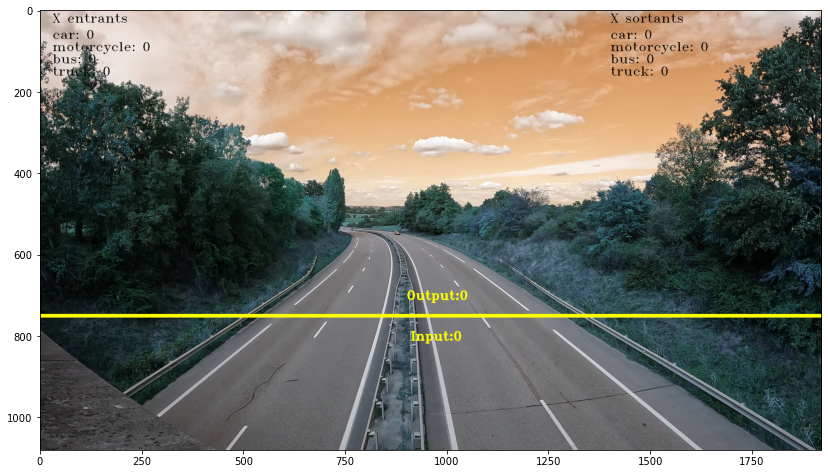

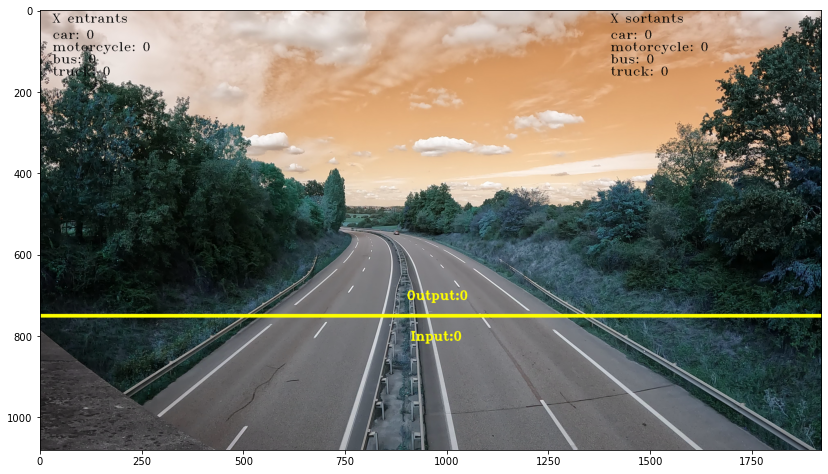

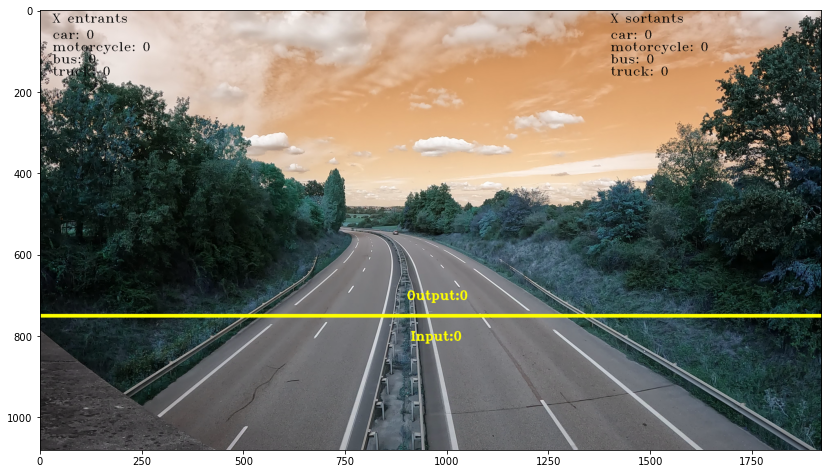

In [10]:
# Checking samples of processed frames
for i in [28, 29, 32, 40, 42, 50, 58]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()

# Executing Result Video 

In [11]:
#output video result
frac = 0.7 
Video(data='rep_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))